In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader
from zuko.utils import odeint
from tqdm import tqdm
from typing import *
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class OTFlowMatching:
    
    def __init__(self, sig_min: float = 0.001) -> None:
        super().__init__()
        self.sig_min = sig_min
        self.eps = 1e-5
    
    def conditional_ot_flow(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        while t.dim() < x.dim():
            t = t.unsqueeze(-1)
        t = t.expand(x.shape)
        return (1 - (1 - self.sig_min) * t) * x + t * x_1
    
    def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
        
        t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
        t = t[:, None].expand(x_1.shape)
        x_0 = torch.randn_like(x_1) 
        
        v_psi = v_t(t[:,0], self.conditional_ot_flow(x_0, x_1, t))
        d_psi = x_1 - (1 - self.sig_min) * x_0
        
        return torch.mean((v_psi-d_psi) ** 2)

In [3]:
class CondVF(nn.Module):
  def __init__(self, net: nn.Module, n_steps: int = 100) -> None:
    super().__init__()
    self.net = net

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return self.net(t, x)
    
  def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
      t = t * torch.ones(len(x), device=x.device)
      return self(t, x)

  def decode_t0_t1(self, x_0, t0, t1):
    return odeint(self.wrapper, x_0, t0, t1, self.parameters())


  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_0, 0., 1., self.parameters())


class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies:int) -> None:
    super().__init__()

    ins = [in_dim + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))
  
  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)
    
  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = self.time_encoder(t)
    x = torch.cat((x, t), dim=-1)
    
    for l in self.layers:
      x = l(x)
    return self.top(x)

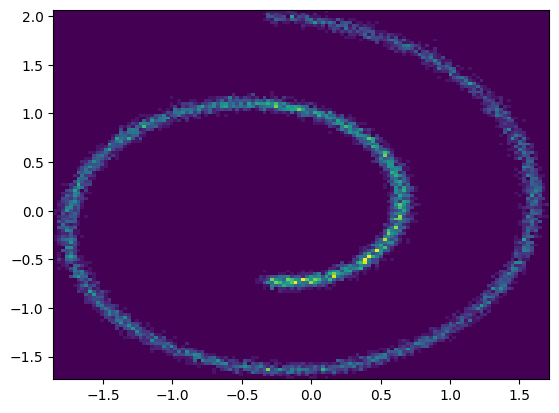

In [4]:
def get_data(dataset: str, n_points: int) -> np.ndarray:
  if dataset == "moons":
    data, _ = make_moons(n_points, noise=0.15)
  elif dataset == "swiss":
    data, _ = make_swiss_roll(n_points, noise=0.25)
    data = data[:, [0, 2]] / 10.0
  return StandardScaler().fit_transform(data)


n_points = 10_000
DATASET = "swiss"
data = get_data(DATASET, n_points)

%matplotlib inline
plt.hist2d(data[:, 0], data[:, 1], bins=128)
plt.show()

In [5]:
batch_size = 2048
dataset = torch.from_numpy(data).float()
dataset = dataset.to(device)
dataset = TensorDataset(dataset) 
dataloader = DataLoader(dataset, batch_size=batch_size)

In [6]:
MODEL = "ot"
model = OTFlowMatching()
net = Net(2, 2, [512]*5, 10).to(device)
v_t = CondVF(net)    

losses = [] 
# configure optimizer
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)
n_epochs = 500

In [7]:
'''
MODEL = "ot"
model = OTFlowMatching()
net = Net(2, 2, [512]*5, 10).to(device)
v_t = CondVF(net)    

losses = [] 
# configure optimizer
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)
n_epochs = 500
    
for epoch in tqdm(range(n_epochs), ncols=88):
    for batch in dataloader:
      x_1 = batch[0]
      # compute loss 
      loss = model.loss(v_t, x_1)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses += [loss.detach()]

# Sampling
n_samples = 10_000
with torch.no_grad():
    x_0 = torch.randn(n_samples, 2, device=device)
    x_1_hat = v_t.decode(x_0)
    

%matplotlib inline
import matplotlib.pyplot as plt
x_1_hat = x_1_hat.cpu().numpy()
plt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=164)
plt.show()
'''

'\nMODEL = "ot"\nmodel = OTFlowMatching()\nnet = Net(2, 2, [512]*5, 10).to(device)\nv_t = CondVF(net)    \n\nlosses = [] \n# configure optimizer\noptimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)\nn_epochs = 500\n    \nfor epoch in tqdm(range(n_epochs), ncols=88):\n    for batch in dataloader:\n      x_1 = batch[0]\n      # compute loss \n      loss = model.loss(v_t, x_1)\n      optimizer.zero_grad()\n      loss.backward()\n      optimizer.step()\n      losses += [loss.detach()]\n\n# Sampling\nn_samples = 10_000\nwith torch.no_grad():\n    x_0 = torch.randn(n_samples, 2, device=device)\n    x_1_hat = v_t.decode(x_0)\n    \n\n%matplotlib inline\nimport matplotlib.pyplot as plt\nx_1_hat = x_1_hat.cpu().numpy()\nplt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=164)\nplt.show()\n'

  2%|▉                                                  | 9/500 [00:05<05:17,  1.55it/s]

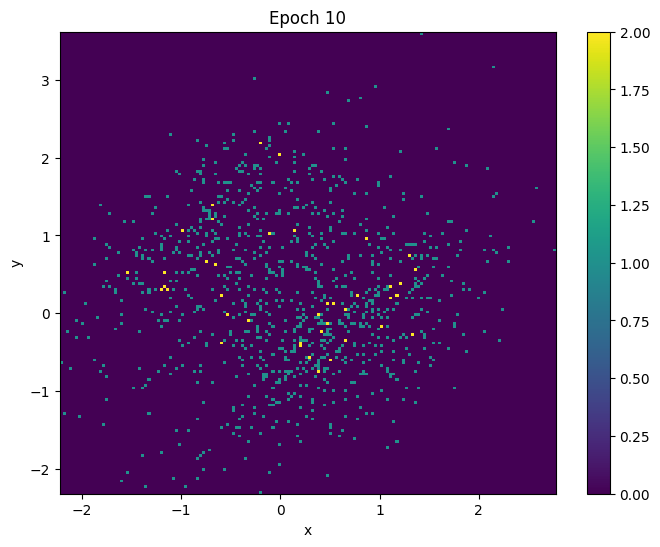

  4%|█▉                                                | 19/500 [00:28<06:41,  1.20it/s]

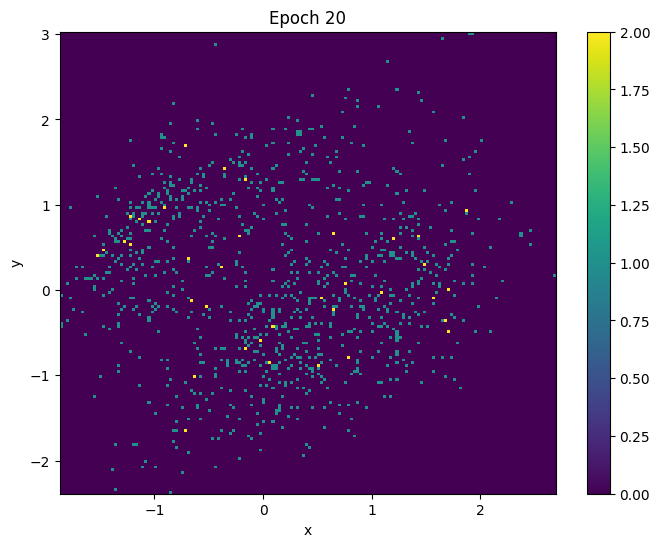

  6%|██▉                                               | 29/500 [00:57<07:39,  1.02it/s]

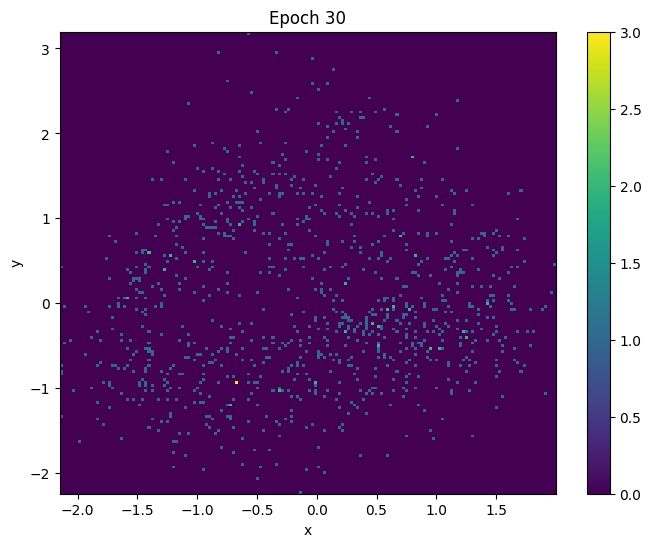

  8%|███▉                                              | 39/500 [01:34<08:10,  1.06s/it]

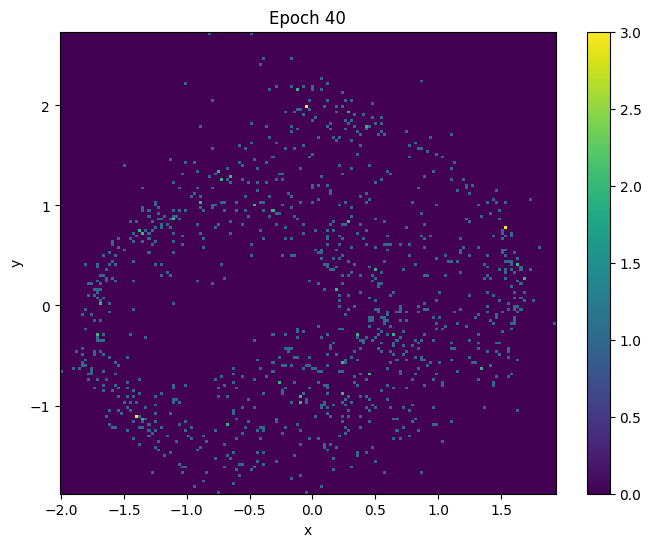

 10%|████▉                                             | 49/500 [02:20<08:55,  1.19s/it]

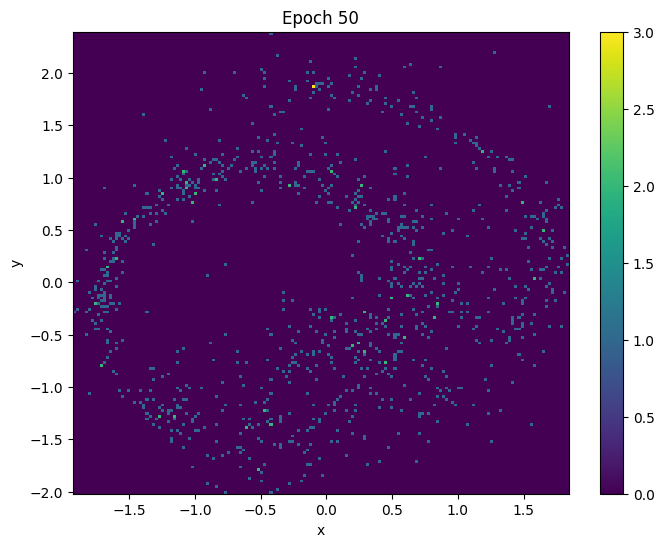

 12%|█████▉                                            | 59/500 [03:10<09:27,  1.29s/it]

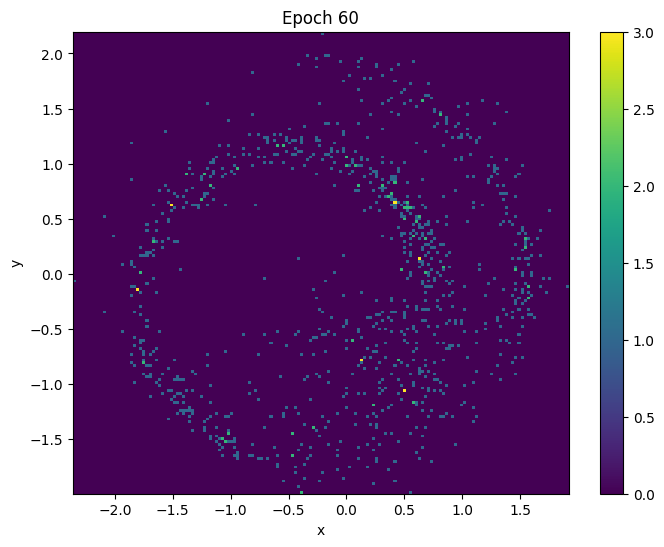

 14%|██████▉                                           | 69/500 [04:11<10:12,  1.42s/it]

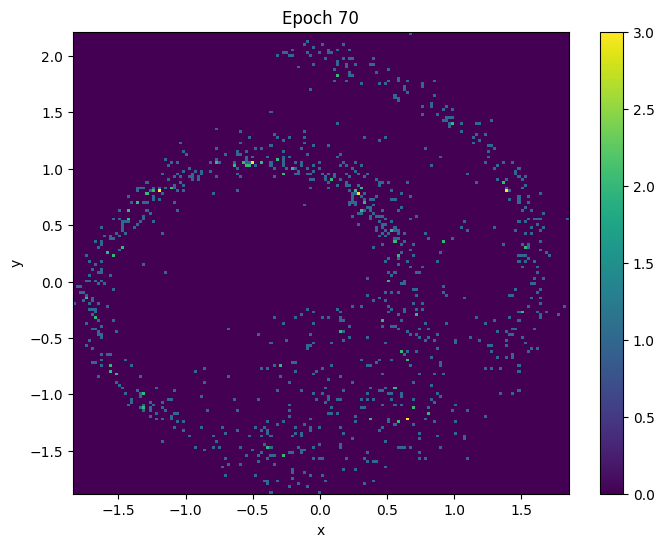

 16%|███████▉                                          | 79/500 [04:59<08:57,  1.28s/it]

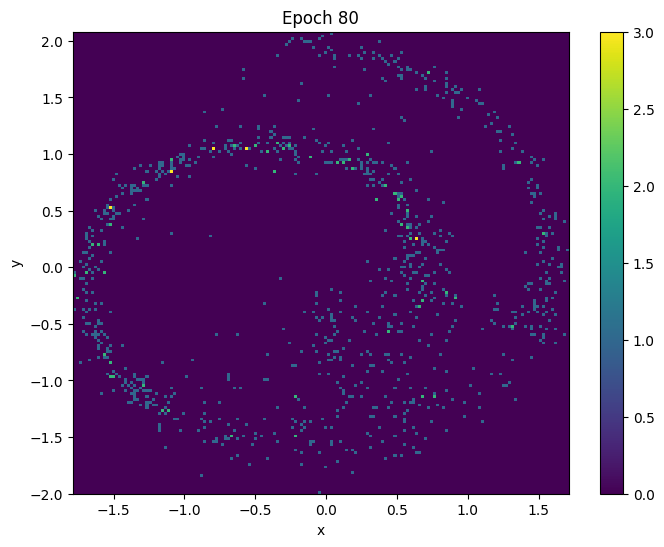

 18%|████████▉                                         | 89/500 [05:43<08:02,  1.17s/it]

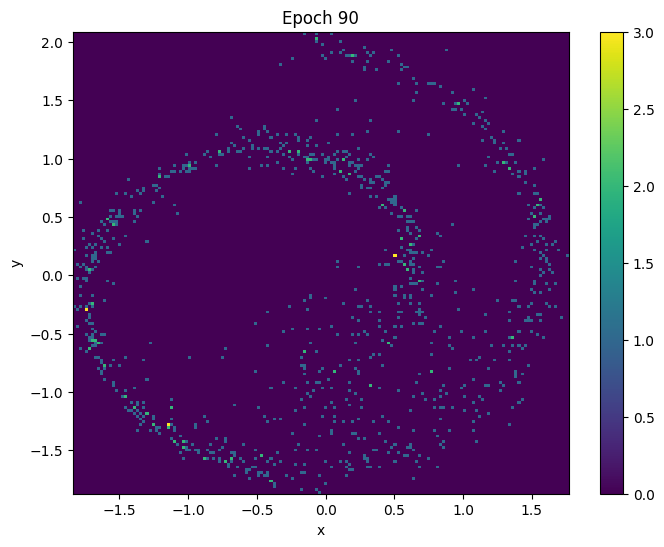

 20%|█████████▉                                        | 99/500 [06:24<07:22,  1.10s/it]

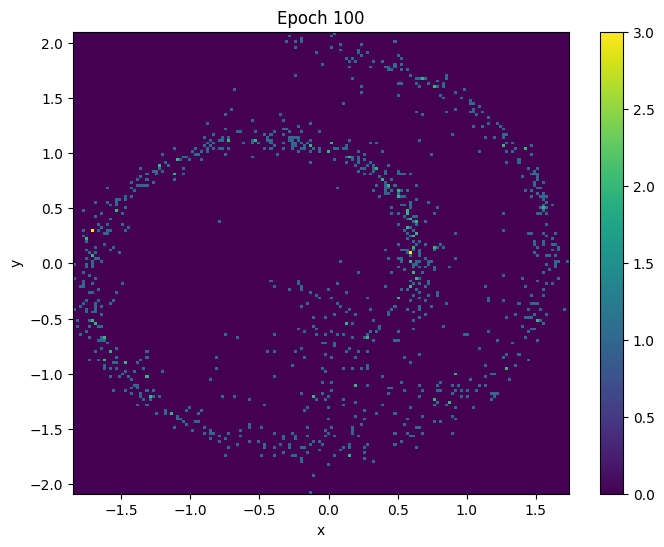

 22%|██████████▋                                      | 109/500 [07:08<08:02,  1.23s/it]

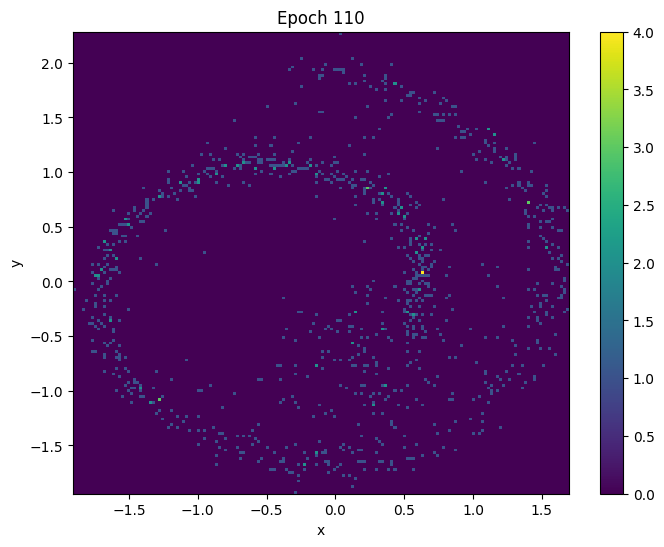

 24%|███████████▋                                     | 119/500 [07:50<07:03,  1.11s/it]

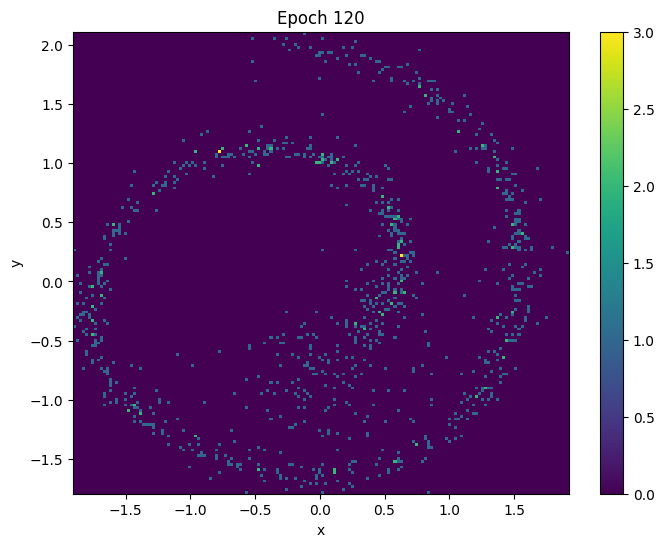

 26%|████████████▋                                    | 129/500 [08:30<06:43,  1.09s/it]

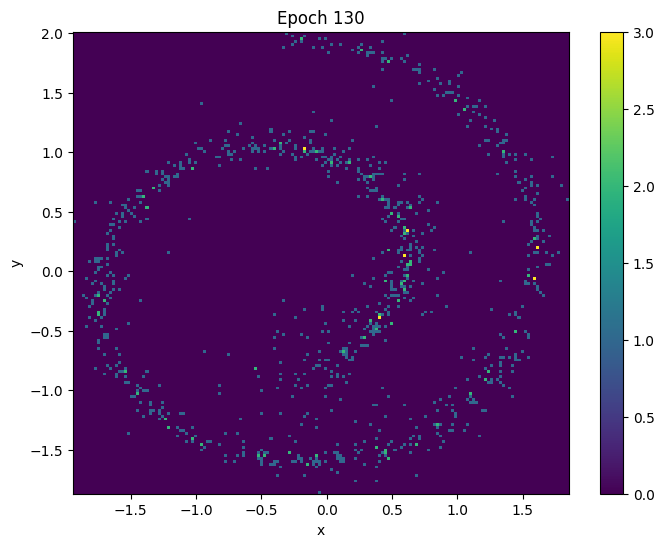

 28%|█████████████▌                                   | 139/500 [09:14<06:57,  1.16s/it]

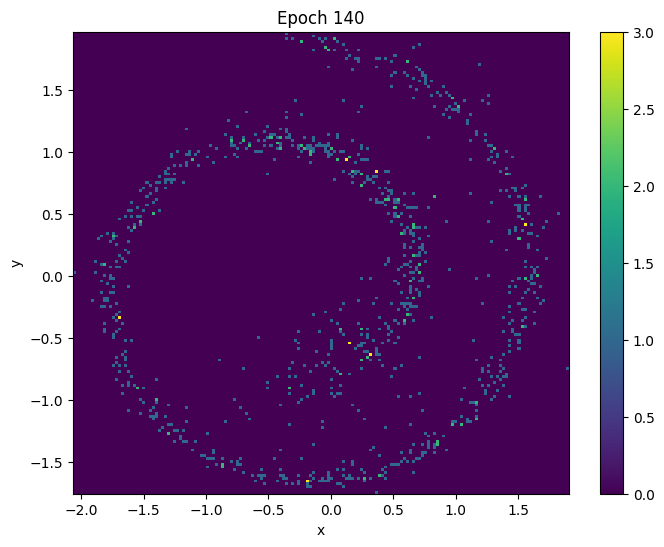

 30%|██████████████▌                                  | 149/500 [10:19<24:18,  4.15s/it]


KeyboardInterrupt: 

In [8]:
for epoch in tqdm(range(n_epochs), ncols=88):
    for batch in dataloader:
        x_1 = batch[0]
        # Compute loss
        loss = model.loss(v_t, x_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().item())

    # Sampling and visualization every 10 epochs
    if (epoch + 1) % 10 == 0:
        n_samples = 1_000
        with torch.no_grad():
            x_0 = torch.randn(n_samples, 2, device=device)
            x_1_hat = v_t.decode(x_0)

            x_1_hat = x_1_hat.cpu().numpy()
            plt.figure(figsize=(8, 6))
            plt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=164, cmap='viridis')
            plt.colorbar()
            plt.title(f'Epoch {epoch + 1}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.show()